In [76]:
import pandas as pd

In [77]:
import numpy as np

In [78]:
import os

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
from sklearn.metrics import r2_score


In [81]:
from sklearn.preprocessing import StandardScaler


In [82]:
import statsmodels.api as sm


In [83]:
from sklearn.model_selection import train_test_split

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [85]:
from sklearn.linear_model import LinearRegression


In [86]:
from sklearn.metrics import mean_absolute_error

In [87]:
from sklearn.metrics import mean_squared_error


In [88]:
from sklearn.metrics import mean_absolute_percentage_error

In [89]:
from sklearn.preprocessing import PolynomialFeatures

In [101]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
df = pd.read_csv('/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_106.csv')

In [91]:
def three_hour_df(homeid):
    df = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

    df['time'] = pd.to_datetime(df['time'])

    categorical_data = df[['time','weather_code (wmo code)']].copy()
    df.drop(columns=['weather_code (wmo code)', 'electric_combined_1h_forecast'], inplace=True)
   
    df.set_index('time', inplace=True)
    df = df.resample('3H').mean().round(2)
    categorical_data.set_index('time', inplace=True)
    categorical_data = categorical_data.resample('3H').apply(lambda x: x.mode().iloc[0])
    df['electric-combined_3H-forecast'] = df['electric-combined'].shift(-1)
    df = pd.concat([df, categorical_data], axis=1)
    df= df.dropna()

    end_col = df.pop('electric-combined_3H-forecast')
    df['electric-combined_3H-forecast'] = end_col

    if os.path.exists(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv'):
        print(f'file already exists for {homeid}')
    else:
        df.to_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv')

    return df

In [92]:
df_107 = three_hour_df(107)

/var/folders/ch/cdbcz7115ms5zvq6n9ds4wn00000gn/T/ipykernel_25924/1310957136.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('3H').mean().round(2)
/var/folders/ch/cdbcz7115ms5zvq6n9ds4wn00000gn/T/ipykernel_25924/1310957136.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  categorical_data = categorical_data.resample('3H').apply(lambda x: x.mode().iloc[0])


In [99]:
def forecast(homeid):
    #lets add my time series info to the dataframe
    desired_features = ['hot-water-hot-pipe', 'gas','electric_combined_1W_lagged', 'electric-combined',
       'central-heating-flow', 'hot-water-cold-pipe',
       'temperature_2m (°C)', 'relative_humidity_2m (%)','wind_speed_10m (km/h)', 'day', 'hour', 'weather_code (wmo code)']
    df = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/3h_csv/hourly_{homeid}.csv')
    df.dropna(inplace=True)

    y = df.pop('electric-combined_3H-forecast')


    X = df[desired_features]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=96, shuffle=False)

    def linear_regression_model(X_train, y_train, X_test, y_test, homeid):

        linear_model = LinearRegression()
        linear_model.fit(X_train,y_train)
        #y_pred = pd.Series(linear_model.predict(X_train), index = y_train.index)
        y_fore_poly = pd.Series(linear_model.predict(X_test), index = y_test.index)
        
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_poly'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_poly'] = y_fore_poly

        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        org_csv = org_csv['time']

        plot_data['time'] = org_csv
        plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Linear Regression Model')

        #lets check errors
        print('Linear Regression:')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_poly)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_poly)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_poly)}')

        print('______________')

    #     svrgs_parameters = {
    #     'kernel': ['rbf'],
    #     'C':     [150000,200000,250000],
    #     'gamma': [0.004,0.0045,0.005]
    # }
    
    def poly_regresssion_model(X_train, y_train, X_test, y_test, homeid):
        poly = PolynomialFeatures(degree=3)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)
        y_fore_poly = poly_model.predict(X_test_poly)
        print('Polynomial regression')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_poly)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_poly)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_poly)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_poly'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_poly'] = y_fore_poly

        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        org_csv = org_csv['time']

        plot_data['time'] = org_csv
        plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next hour 3 prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Polynomial Regression Model')



    def support_vector_regression(X_train, y_train, X_test, y_test, homeid):
        from sklearn.svm import SVR
        svr = SVR()
        svr.fit(X_train, y_train)
        y_fore_svr = svr.predict(X_test)
        print('Support Vector Regression')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_svr)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_svr)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_svr)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_svr'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_svr'] = y_fore_svr

        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        org_csv = org_csv['time']

        plot_data['time'] = org_csv
        plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Support Vector Regression')
    
    def random_forest_model(X_train, y_train, X_test, y_test, homeid):
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        y_fore_rf = rf.predict(X_test)
        print('Random Forest')
        print(f'mean absolute error: {mean_absolute_error(y_test, y_fore_rf)}')
        print(f'mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_fore_rf)}')
        print(f'R-squared error: {r2_score(y_test, y_fore_rf)}')
        print('______________')
        plot_data = pd.DataFrame(columns=['y_test', 'y_fore_rf'])
        plot_data['y_test'] = y_test
        plot_data['y_fore_rf'] = y_fore_rf

        org_csv = pd.read_csv(f'/Users/barry/CodeAcademy/Ideal_dataset/updated_hourly_csv/hourly_{homeid}.csv')

        
        org_csv = org_csv['time']

        plot_data['time'] = org_csv
        plot_data.set_index('time', inplace=True)
        
        fig, axs = plt.subplots(figsize=(20,10))
        fig1 = sns.lineplot(data=plot_data, ax=axs, markers=True, dashes=False)
        plt.xticks(ticks= plot_data.index, rotation=90)
        axs.set_title(f'contrasting next 3 hour prediciton with actuals over 7 days: homeid {homeid}')
        plt.suptitle('Random Forest Model')

    support_vector_regression(X_train, y_train, X_test, y_test, homeid)

    poly_regresssion_model(X_train, y_train, X_test, y_test, homeid)

    linear_regression_model(X_train, y_train, X_test, y_test, homeid)
        
    random_forest_model(X_train, y_train, X_test, y_test, homeid)

    


Support Vector Regression
mean absolute error: 9.318821745683374
mean absolute percentage error: 861522157383343.1
R-squared error: -0.08886802080677536
______________
Polynomial regression
mean absolute error: 8.275560343566298
mean absolute percentage error: 1407294684269235.8
R-squared error: 0.3028866255283663
______________


/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: F

Linear Regression:
mean absolute error: 9.807812958148306
mean absolute percentage error: 4171836385665166.5
R-squared error: 0.24241799910688733
______________
Random Forest
mean absolute error: 7.672320833333333
mean absolute percentage error: 1751266936349524.0
R-squared error: 0.425947634249798
______________


/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/barry/anaconda3/envs/IdealDataInterface/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


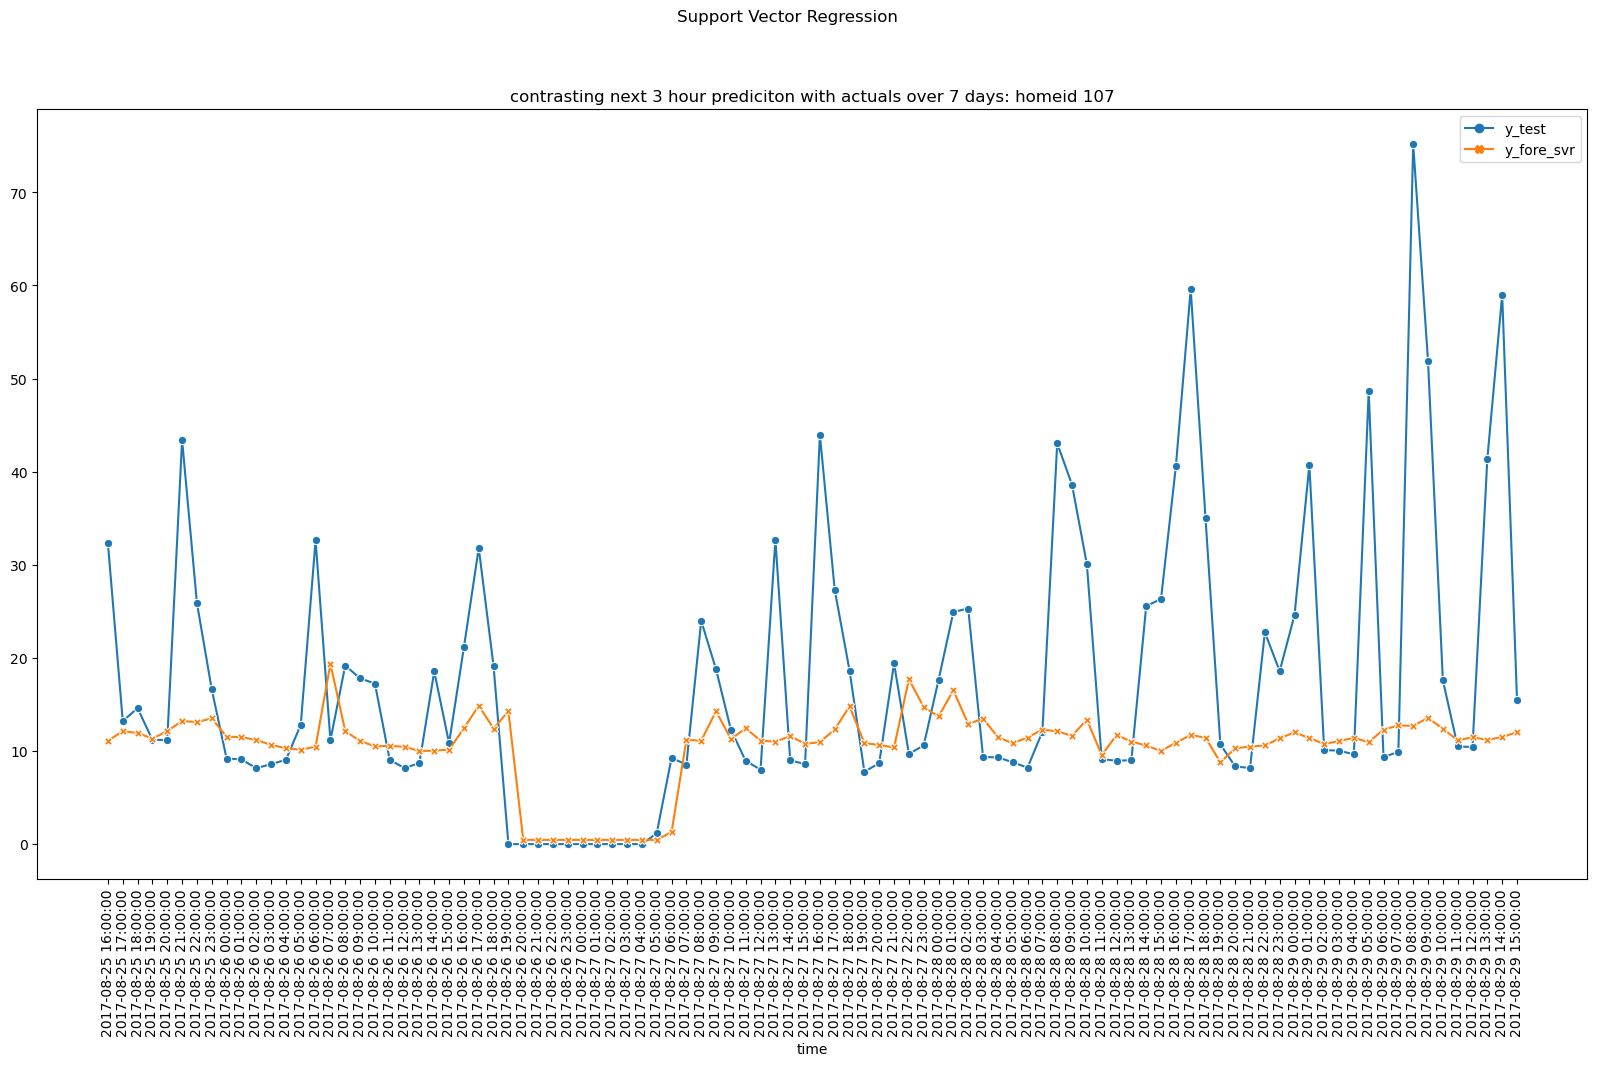

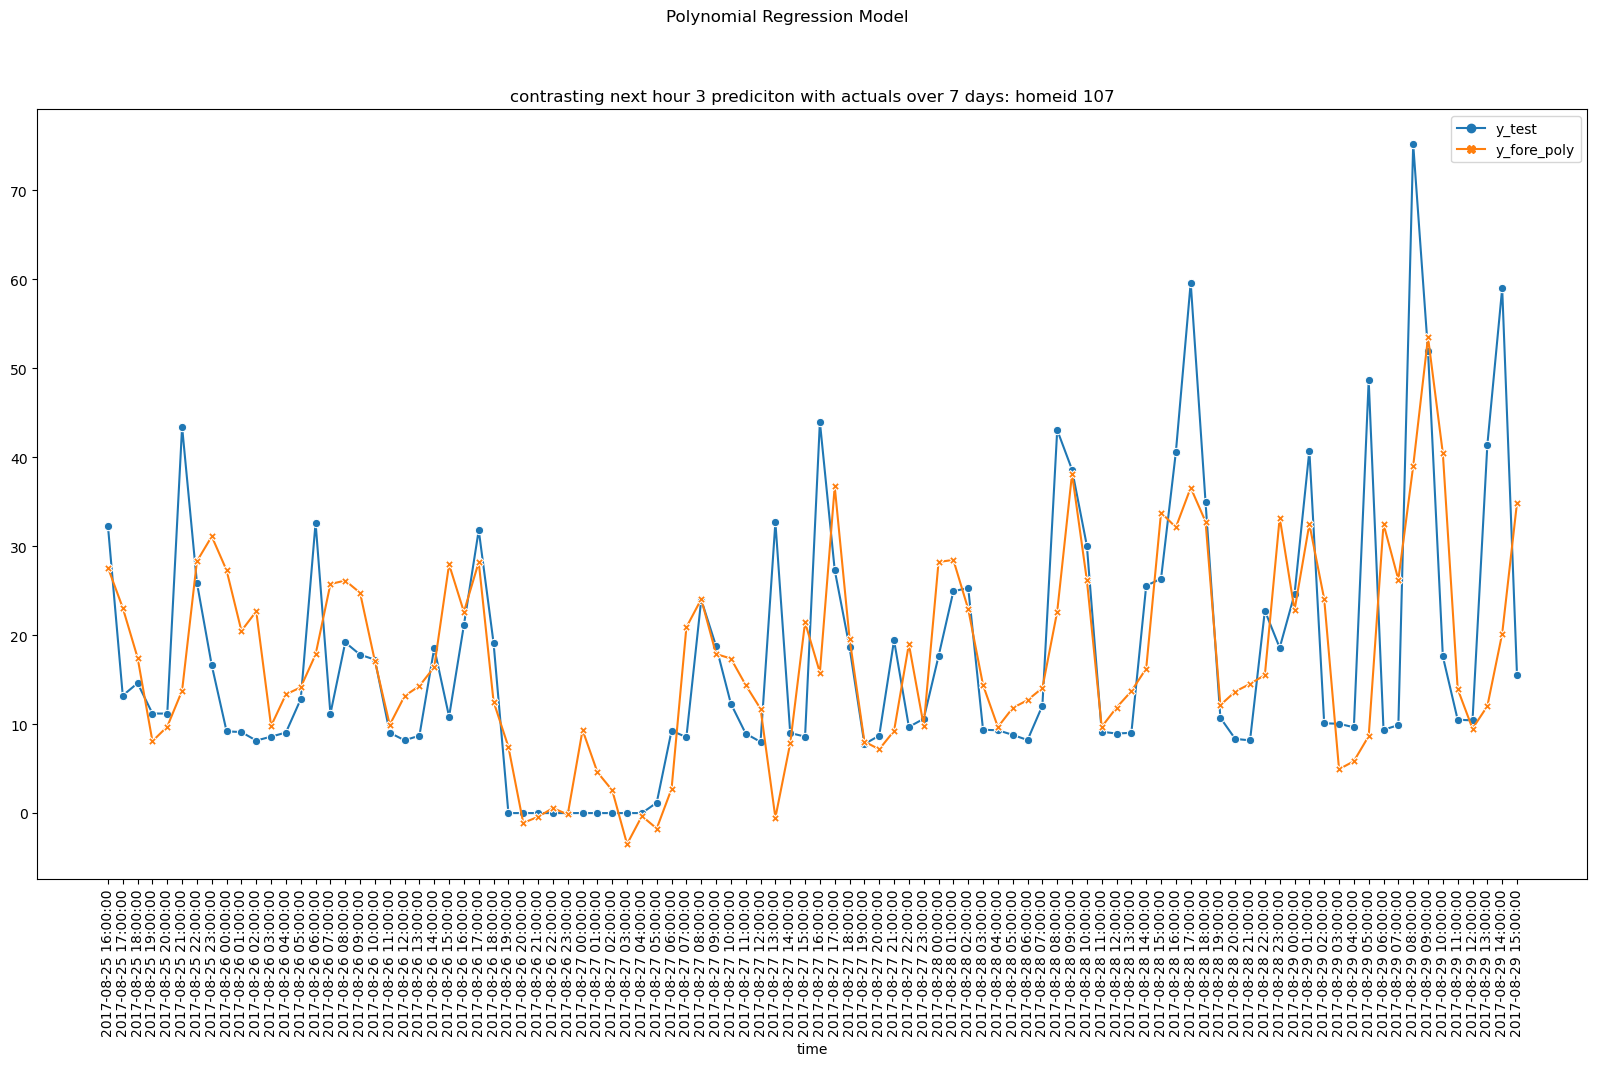

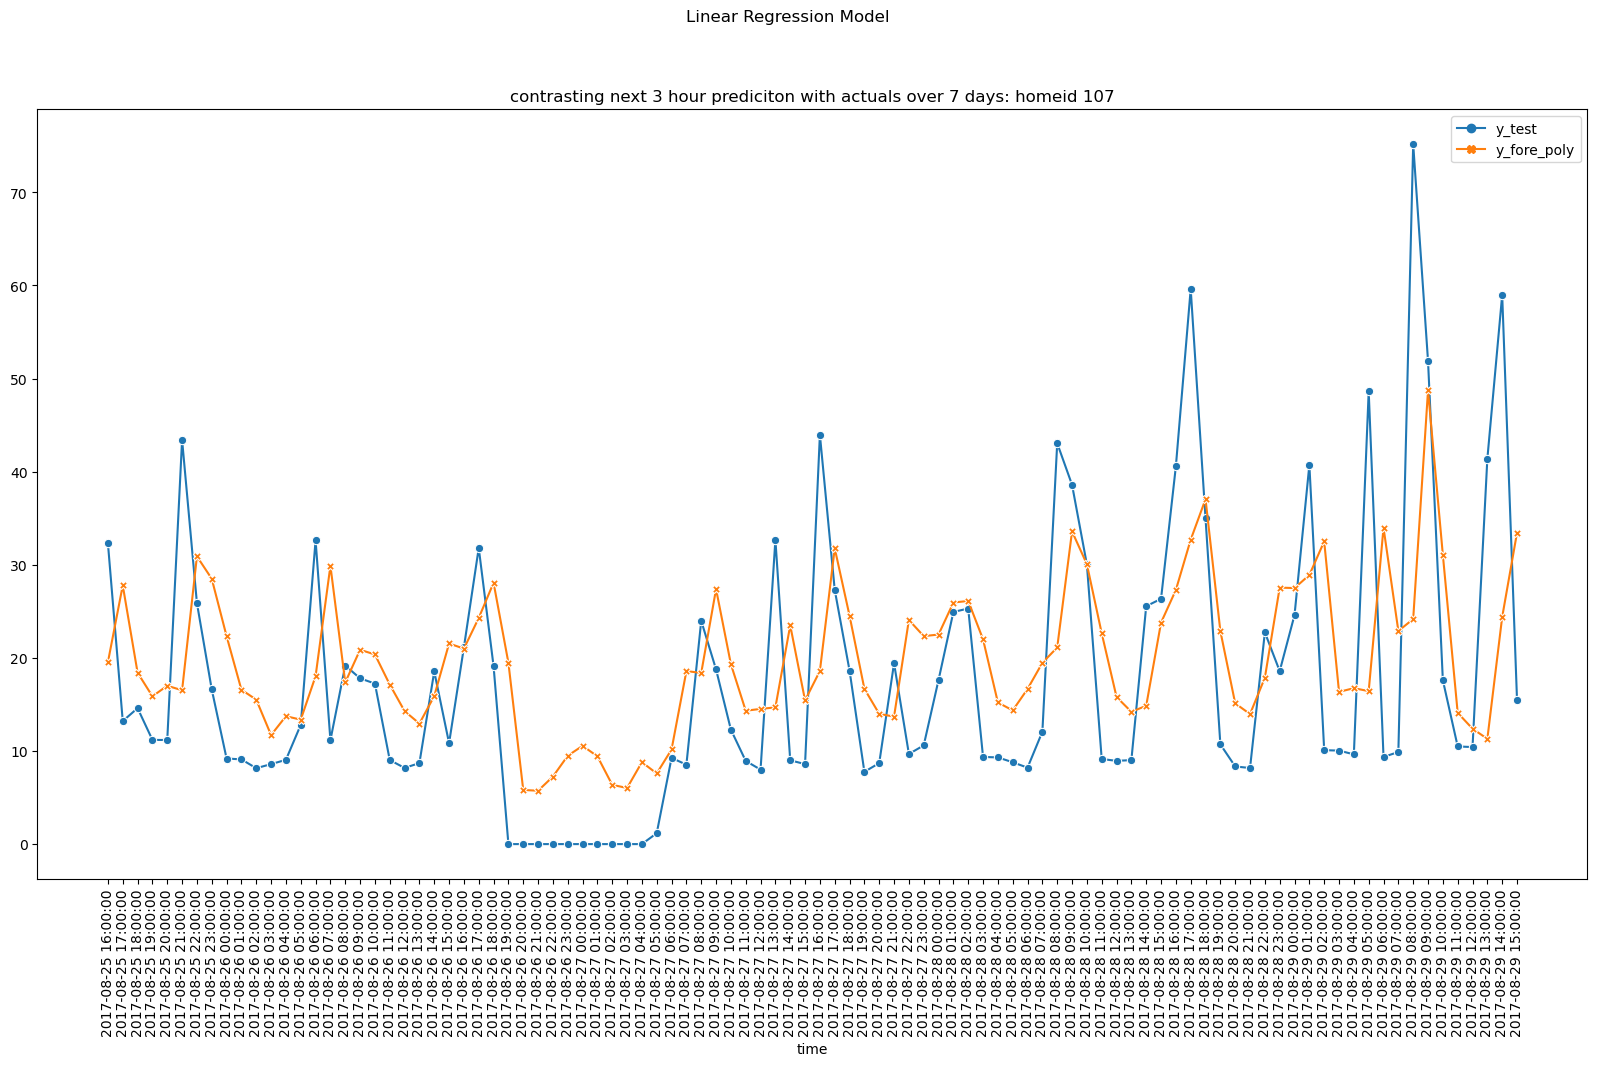

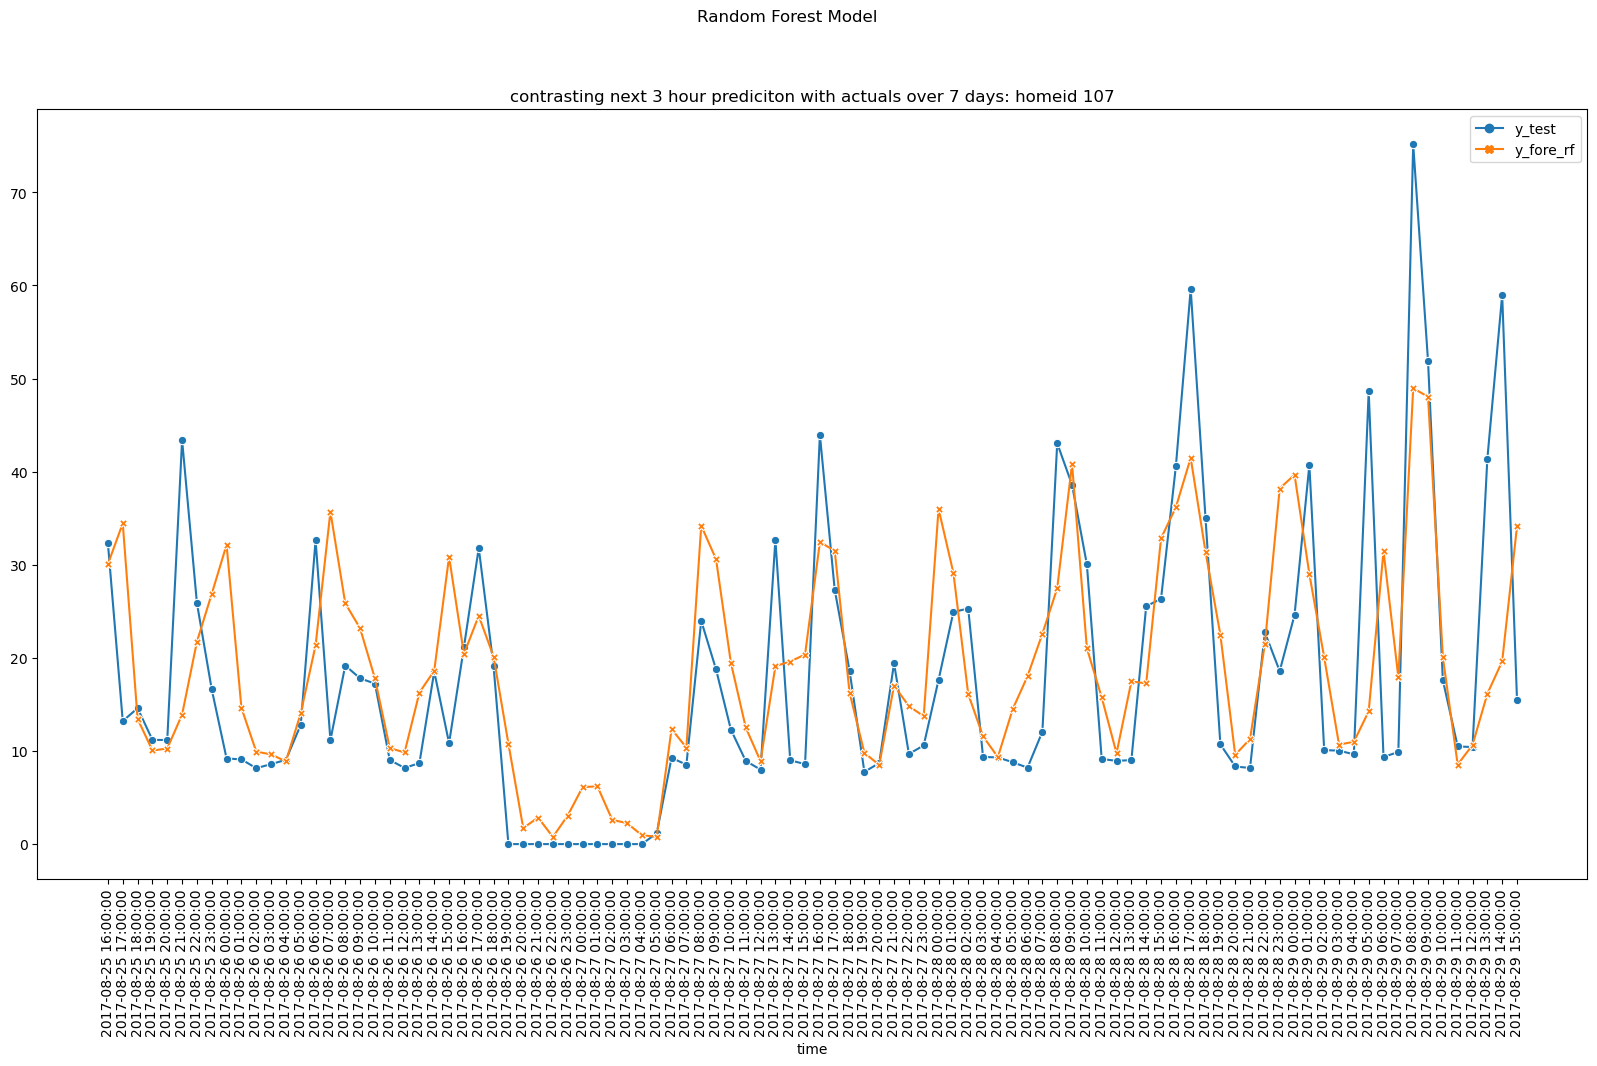

In [100]:
forecast(107)

Support Vector Regression
mean absolute error: 7.339299862420248
mean absolute percentage error: 0.48765234584618744
R-squared error: -0.15827293588576996
______________
Polynomial regression
mean absolute error: 7.897890536578575
mean absolute percentage error: 0.6992346474892649
R-squared error: -0.05741350550801205
______________
Linear Regression:
mean absolute error: 7.521885940791971
mean absolute percentage error: 0.7338626893702033
R-squared error: 0.14941688895967975
______________
Random Forest
mean absolute error: 6.166829166666667
mean absolute percentage error: 0.496416655897644
R-squared error: 0.27039066645588816
______________


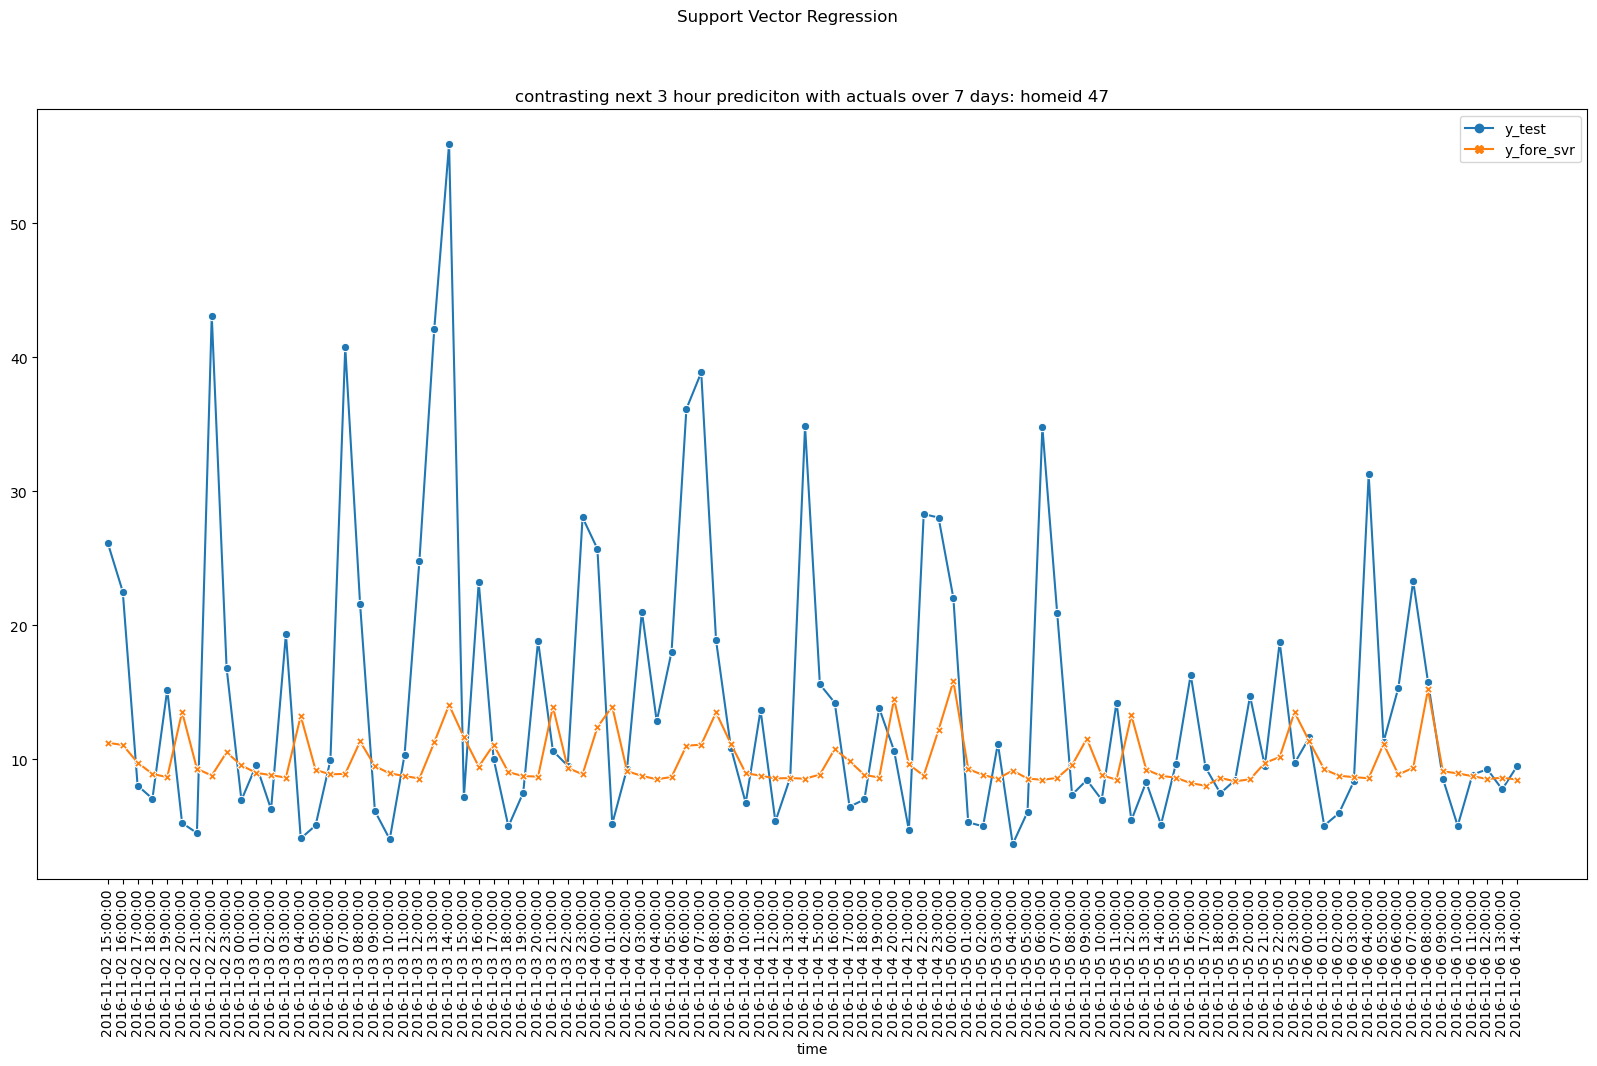

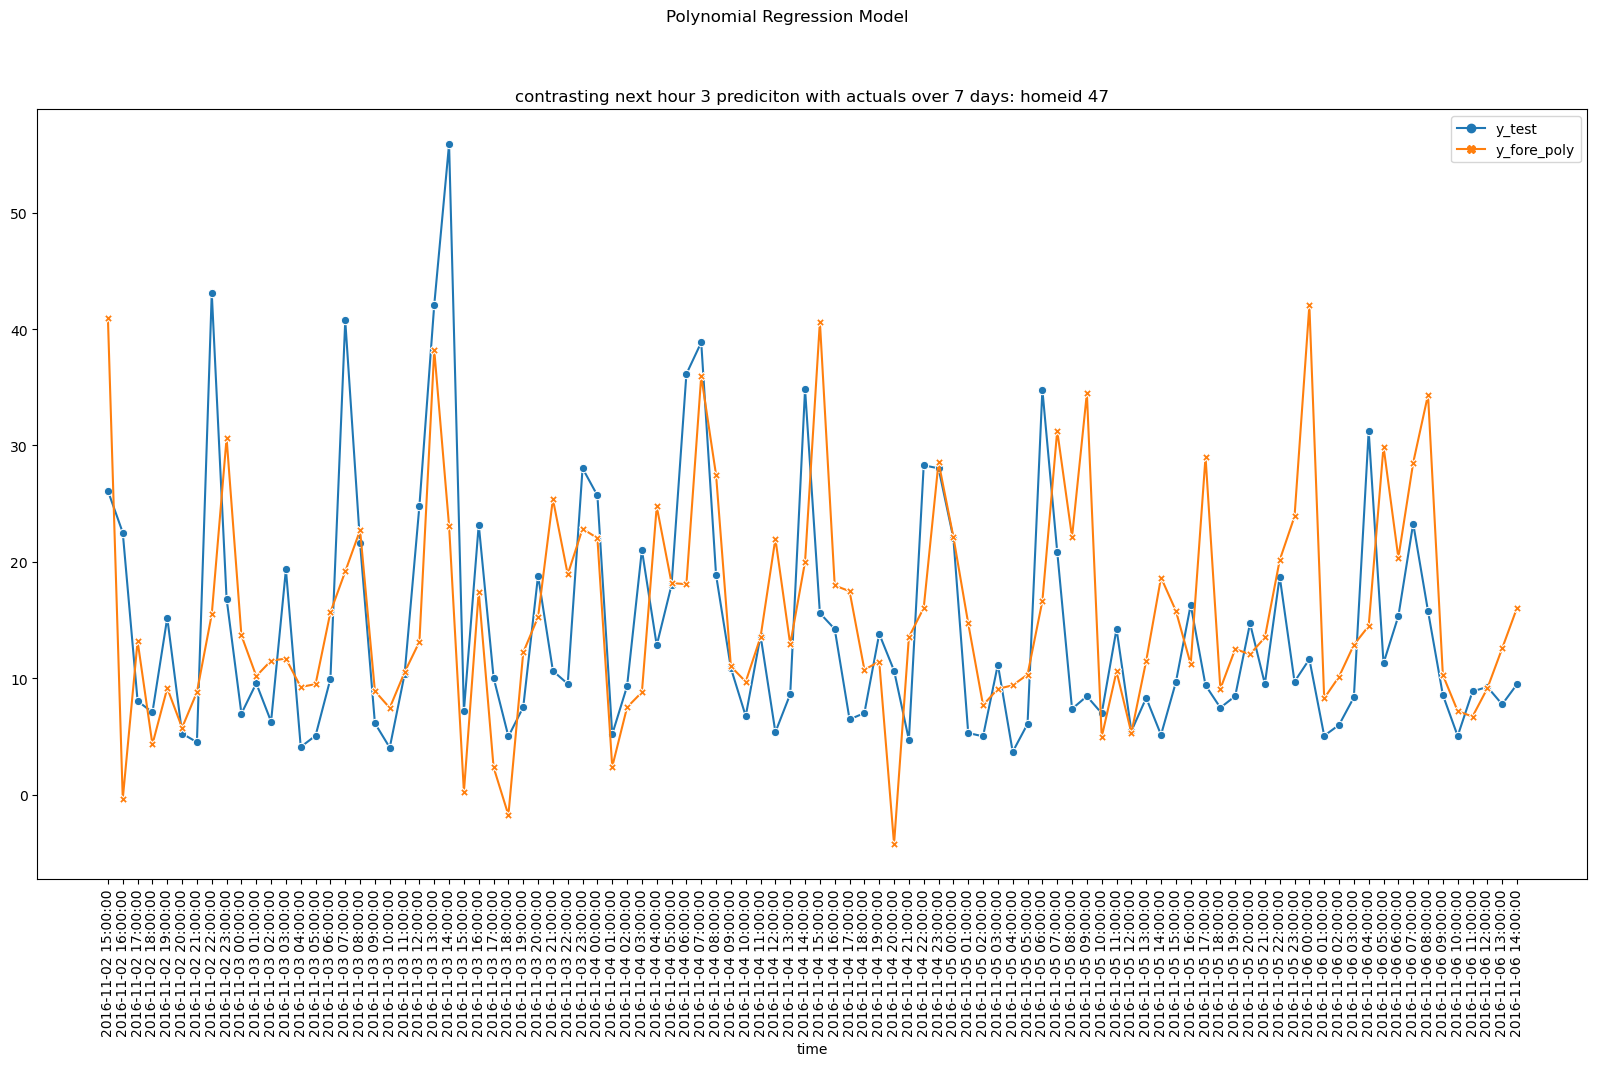

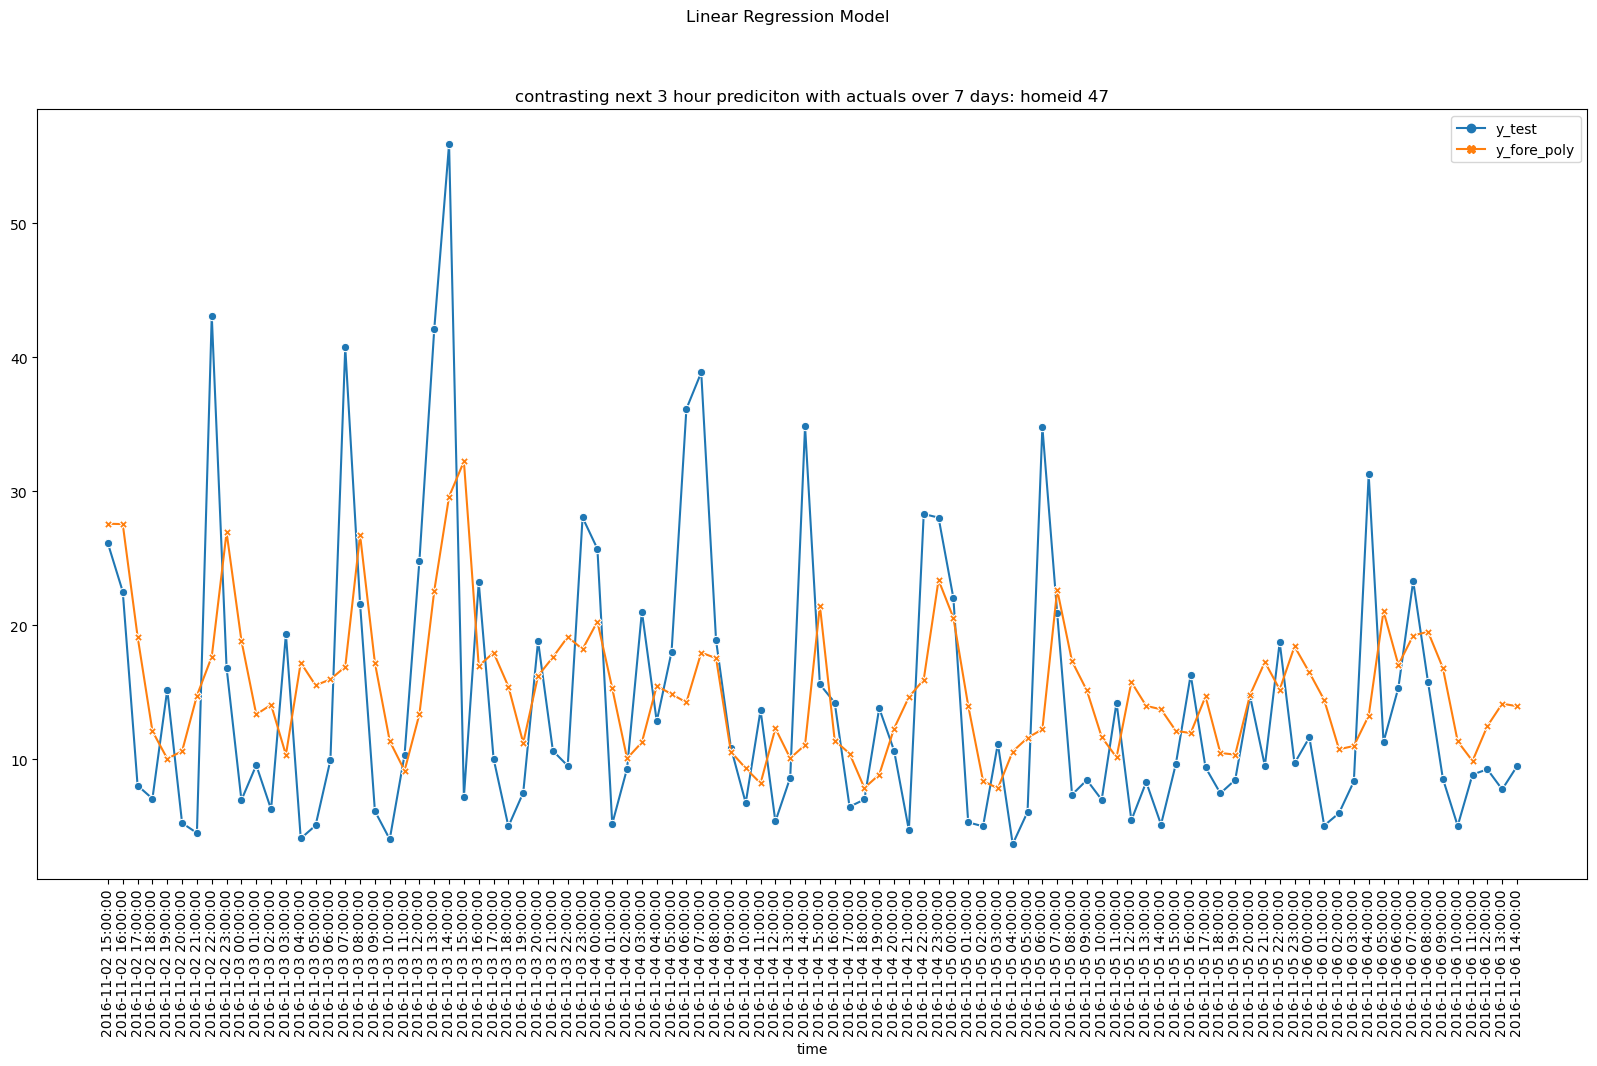

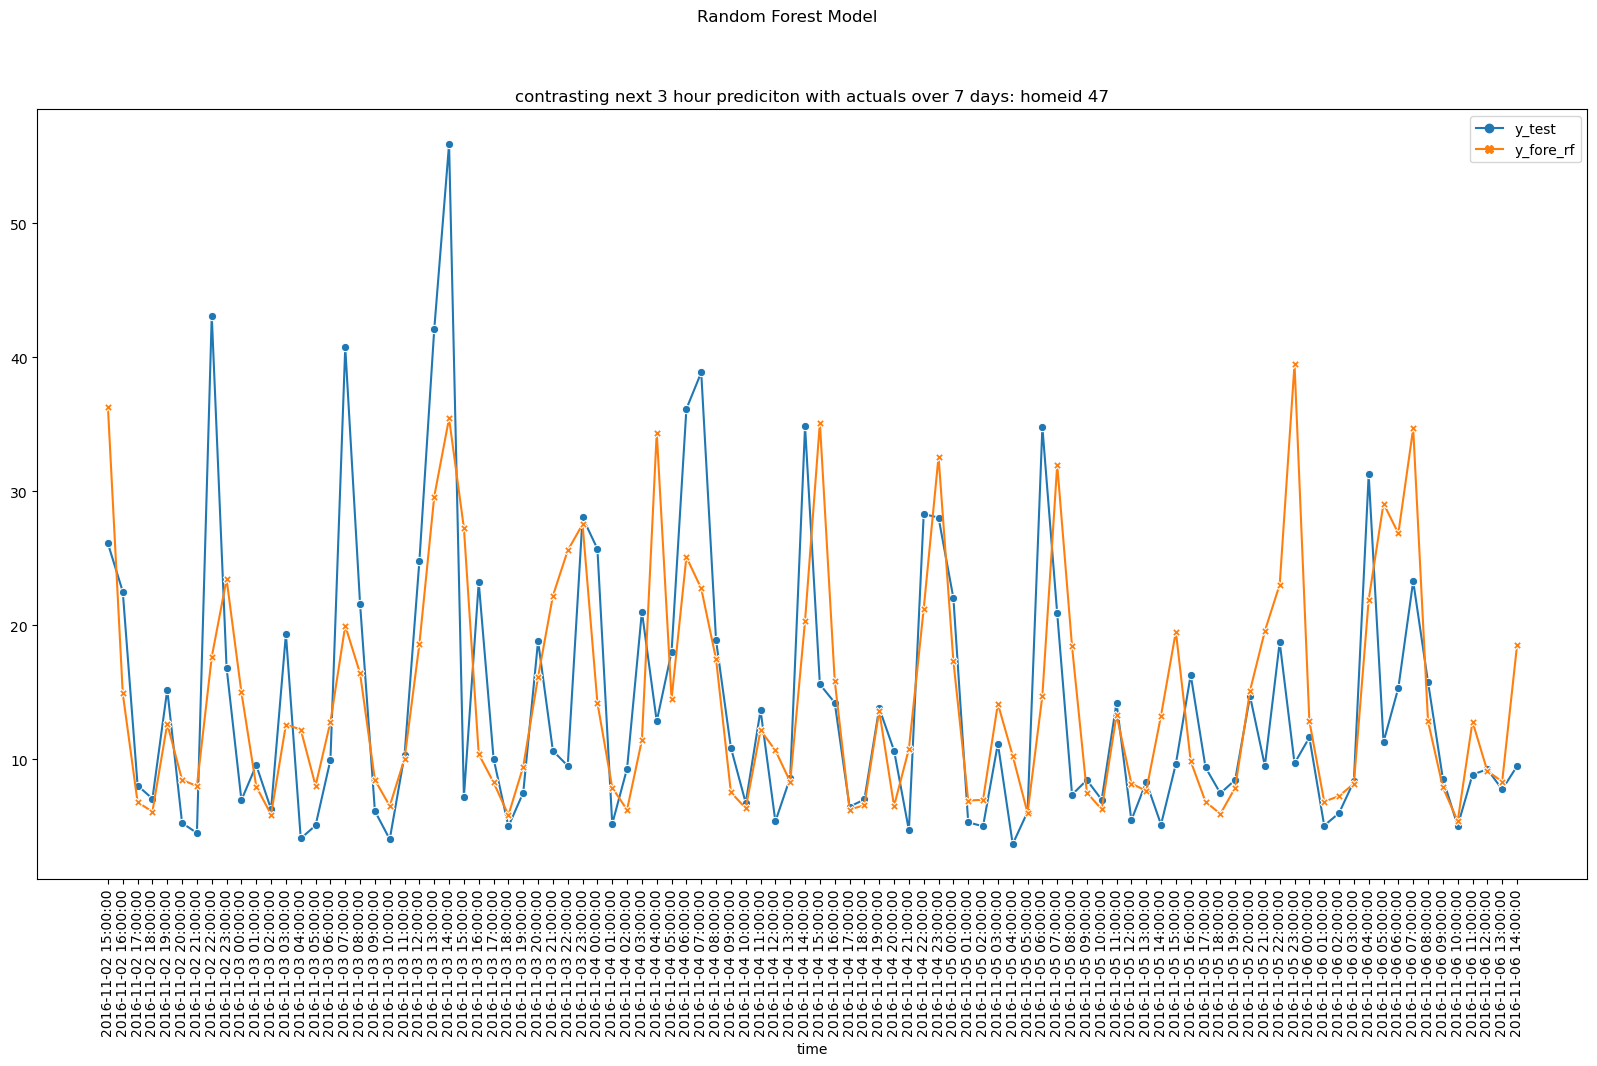

In [102]:
forecast(47)